# Imports

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import joblib
import os
from typing import Optional, Union
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as tfkl
import tensorflow.keras as tfk
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Pipeline

In [ ]:
class WindTurbinePipeline:
    def __init__(self,
                 model_weights_path: Optional[str] = None,
                 scaler: Union[str, MinMaxScaler, None]= None) -> None:
        """
        Initializes the WindTurbinePipeline class.

        Parameters:
        - model_weights_path (str, optional): Path to saved model weights.
        - scaler (StandardScaler, optional): Scikit-learn MinMaxScaller object for feature scaling.

        Raises:
        - ValueError: If model_weights_path is provided but scaler is None.
        """

        self.model_weights_path = model_weights_path
        self.callbacks = self.__get_callbacks()

        # Setting a default scaler if none is provided
        self.scaler = scaler

        self.batch_size = 4096
        self.input_steps = 64
        self.output_steps = 12
        self.model = self.__build_complex_seq2seq()

        if self.model_weights_path is not None and os.path.isfile(self.model_weights_path):
            self.model.load_weights(model_weights_path)

        if isinstance(self.scaler, str):
            self.scaler = joblib.load(self.scaler)


    def train(self, data: pd.DataFrame, epoch=50):
        if data is None or data.empty:
            raise ValueError("Data for training cannot be empty.")

        df = self.preprocess(data)
        if self.scaler is None:
            self.scaler = MinMaxScaler(feature_range=(-1, 1))
            self.scaler.fit(df)

        scaled_df = pd.DataFrame(self.scaler.transform(df), columns=df.columns)
        scaled_df.index = df.index

        # Split in test_train
        split_point = int(0.8 * len(scaled_df))
        train = scaled_df.iloc[:split_point]
        test = scaled_df.iloc[split_point:]

        adjusted_train_data = self.TrainingDataGenerator(train, self.input_steps, self.output_steps, self.batch_size)
        adjusted_test_data = self.TrainingDataGenerator(test, self.input_steps, self.output_steps, self.batch_size)

        history = self.model.fit(
            x=adjusted_train_data,
            epochs=epoch,
            validation_data=adjusted_test_data,
            callbacks=self.callbacks
        )

        self.__plot_loss(history)

        self.model.fit(
            x=adjusted_test_data,
            validation_data=adjusted_test_data,
            epochs=4
        )
        self.model.save_weights(self.model_weights_path)
        joblib.dump(self.scaler, os.path.join(os.path.dirname(self.model_weights_path), "scaler_filename.pkl"))

    def predict(self, data: pd.DataFrame) -> np.ndarray:
        if self.model is None:
            raise Exception("Model has not been trained yet.")

        if self.scaler is None:
            raise ValueError("You should also define a scaler together with the model weights")

        df = self.__preprocess(data)
        scaled_df = pd.DataFrame(self.scaler.transform(df), columns=df.columns)
        scaled_df.index = df.index

        adjusted_data = self.__prepare_data_predict( scaled_df, self.input_steps, self.output_steps)

        predictions = self.model.predict(adjusted_data).flatten()

        # Create dummy arrays with the same shape as the original data
        dummy_array_pred = np.zeros((len(predictions), self.scaler.scale_.shape[0]))
        active_power_col_index = 2  # Assuming 'Active Power avg' is the 3rd column in the original DataFrame
        dummy_array_pred[:, active_power_col_index] = predictions

        predictions = self.scaler.inverse_transform(dummy_array_pred)[:, active_power_col_index]

        return predictions

    def __build_complex_seq2seq(self, input_shape=(64, 16), output_shape=(12, 1), n_hidden=32, n_filters=128,
                                kernel_size=2, dropout=0.6, reg_strength=0.002):
        encoder_inputs = tfkl.Input(shape=input_shape)

        # Smaller kernel size and fewer filters
        conv1d = tfkl.Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu', padding='same')(
            encoder_inputs)

        encoder_l1 = tfkl.Bidirectional(tfkl.GRU(n_hidden, return_sequences=True, return_state=True,
                                                 kernel_regularizer=tf.keras.regularizers.l2(reg_strength)))
        encoder_outputs1, forward_h1, backward_h1 = encoder_l1(conv1d)
        encoder_states1 = [forward_h1, backward_h1]

        # Reduced to one encoder layer for simplicity
        attention = tfkl.Attention(use_scale=True)([encoder_outputs1, encoder_outputs1])
        combined = tfkl.Concatenate(axis=-1)([encoder_outputs1, attention])

        decoder_inputs = tfkl.Input(shape=output_shape)

        decoder_l1 = tfkl.Bidirectional(
            tfkl.GRU(n_hidden, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(reg_strength)))
        decoder_outputs1 = decoder_l1(decoder_inputs, initial_state=encoder_states1)

        # Increased dropout rate
        decoder_outputs1 = tfkl.Dropout(dropout)(decoder_outputs1)

        decoder_outputs = tfkl.TimeDistributed(tfkl.Dense(output_shape[1]))(decoder_outputs1)

        model = tfk.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
        model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

        return model

    def __get_callbacks(self):
        model_checkpoint_callback = ModelCheckpoint(
            filepath=self.model_weights_path,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True
        )

        lr_reducer = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            verbose=1,
            min_lr=1e-5)

        early_stopping_callback = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1)

        return [model_checkpoint_callback, lr_reducer, early_stopping_callback]

    def preprocess(self, df):
        # Make a copy of the input DataFrame
        df = df.copy()

        # Combine 'Datum (Anlage)' and 'Zeit (Anlage)' columns into a single 'DateTime' column and drop the original columns
        df['DateTime'] = pd.to_datetime(df['Datum (Anlage)'] + ' ' + df['Zeit (Anlage)'],
                                        format='%d.%m.%y %H:%M:%S')
        df.drop(columns=['Datum (Anlage)', 'Zeit (Anlage)'], inplace=True)

        # Reducing dimention for the Dataset
        df = df[::3]

        df.set_index('DateTime', inplace=True)

        # Define a list of columns with missing data exceeding 25%
        missing_values_columns = ['Ereignis', 'Error Number', 'Wind Speed (max)', 'Wind Speed (min)',
                                  'Rotor Speed [rpm] (max)', 'Rotor Speed [rpm] (min)',
                                  'Active Power (max)', 'Active Power (min)', 'Wind Direction (avg)',
                                  'Feature 0', 'Feature 5', 'Feature 6', 'Feature 8', 'Feature 9',
                                  'Feature 10', 'Feature 11', 'Feature 13', 'Feature 14', 'Feature 15',
                                  'Feature 19', 'Feature 20', 'Feature 21', 'Feature 22', 'Feature 23',
                                  'Feature 24', 'Feature 25', 'Feature 26', 'Feature 27', 'Feature 29',
                                  'Feature 30', 'Feature 31', 'Feature 32', 'Feature 33', 'Feature 34',
                                  'Feature 35', 'Feature 36', 'Feature 37', 'Feature 38', 'Feature 39',
                                  'Feature 40', 'Feature 41', 'Feature 42', 'Feature 43', 'Feature 44',
                                  'Feature 45', 'Feature 46', 'Feature 47', 'Feature 48', 'Feature 49',
                                  'Feature 50', 'Feature 51', 'Feature 52', 'Feature 53', 'Feature 54',
                                  'Feature 55', 'Feature 56', 'Feature 57', 'Feature 58', 'Feature 59',
                                  'Feature 60', 'Feature 61', 'Feature 62', 'Feature 63', 'Feature 64',
                                  'Feature 65', 'Feature 66', 'Feature 67', 'Feature 68', 'Feature 69',
                                  'Feature 70', 'Feature 71', 'Feature 72', 'Feature 73', 'Feature 74',
                                  'Feature 75', 'Feature 76', 'Feature 77', 'Feature 78', 'Feature 79',
                                  'Feature 80', 'Feature 81', 'Feature 82']

        # Drop columns with missing data exceeding 25%
        df = df.drop(missing_values_columns, axis=1)

        # Replace commas with dots in all columns
        df = df.applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)

        # Remove non-numeric characters from all columns
        df = df.applymap(lambda x: self.remove_non_numeric(x) if isinstance(x, str) else x)

        # Convert all columns (except the last one) to float
        df.iloc[:, :] = df.iloc[:, :].astype(float)

        # Drop columns with high correlation
        df.drop(columns=["Generator Speed [rpm] (avg)",
                         "Feature 16", "Feature 17",
                         "Feature 2", "Feature 18", "Feature 4",
                         "Reactive Power (avg)",
                         ], axis=1, inplace=True)

        # Drop rows with missing data in the 'Wind Speed (avg)' column
        df.dropna(subset=["Wind Speed (avg)"], inplace=True)

        # Forward-fill missing data
        df.fillna(method="ffill", inplace=True)

        df = df.sort_values(by='DateTime', ascending=True)

        hour = 60 * 60
        minute = 60
        day = 60 * 60 * 24
        year = 365.2425 * day

        df['Seconds'] = df.index.map(pd.Timestamp.timestamp)

        df['Day sin'] = np.sin(df['Seconds'] * (2 * np.pi / day))
        df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
        df['Year sin'] = np.sin(df['Seconds'] * (2 * np.pi / year))
        df['Year cos'] = np.cos(df['Seconds'] * (2 * np.pi / year))
        df['hour sin'] = np.sin(df['Seconds'] * (2 * np.pi / hour))
        df['hour cos'] = np.cos(df['Seconds'] * (2 * np.pi / hour))
        df['minute sin'] = np.sin(df['Seconds'] * (2 * np.pi / minute))
        df['minute cos'] = np.cos(df['Seconds'] * (2 * np.pi / minute))
        df = df.drop('Seconds', axis=1)

        df.columns = [self.remove_non_characters(i) for i in df.columns]

        return df

    def remove_non_numeric(self, text):
        new_value = ''.join(filter(lambda x: x.isdigit() or x == '.', text))

        return new_value if new_value != '' else np.nan

    def remove_non_characters(self, text):
        # Using a generator expression and join to filter out non-character elements
        return ''.join(char for char in text if char.isalpha() or (char == " " or char.isdigit()))

    def __plot_loss(self, history):
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.show()

    class TrainingDataGenerator(Sequence):
        """Adjust the shape of data for the model"""

        def __init__(self, df, input_steps, output_steps, batch_size):
            self.df = df
            self.input_steps = input_steps
            self.output_steps = output_steps
            self.batch_size = batch_size
            self.indexes = np.arange(len(df) - (input_steps + output_steps) + 1)

        def __len__(self):
            return len(self.indexes) // self.batch_size

        def __getitem__(self, index):
            start = index * self.batch_size
            end = (index + 1) * self.batch_size
            batch_x, batch_y, decoder_input = [], [], []
            for i in range(start, end):
                x = self.df.iloc[i:i + self.input_steps].values
                y = self.df.iloc[i + self.input_steps:i + self.input_steps + self.output_steps][
                    ['Active Power avg']].values
                decoder_inp = np.zeros(
                    (self.output_steps, 1))  # assuming you want decoder_input to have the shape (output_steps, 1)
                batch_x.append(x)
                batch_y.append(y)
                decoder_input.append(decoder_inp)
            return [np.array(batch_x), np.array(decoder_input)], np.array(batch_y)

    def __prepare_data_predict(self, df, input_steps, output_steps):
        x = df.iloc[-input_steps:].values
        x = np.expand_dims(x, axis=0)  # Expanding dimensions to account for batch size

        decoder_inp = np.zeros((1, output_steps, 1))  # Making this batch-like and compatible with model

        return [x, decoder_inp]


# Import Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Profesional/SmartData Tech Task/example_raw_data.csv", on_bad_lines='skip', delimiter=";", index_col=0)

<ipython-input-21-4aa754659321>:1: DtypeWarning: Columns (3,11,22,23,25,26,30,31,32,36,37,38,39,40,41,42,44,46,50,51,56,58,59,60,61,62,63,64,67,68,69,80) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Profesional/SmartData Tech Task/example_raw_data.csv", on_bad_lines='skip', delimiter=";", index_col=0)


# Initializing

In [ ]:
model_checkpoint = '/content/drive/MyDrive/Profesional/SmartData Tech Task/models/seq2seq/Pipeline/model.keras'

<ipython-input-20-287f4aac0e3e>:196: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, :] = df.iloc[:, :].astype(float)


Epoch 1/35
23/23 [==============================] - 92s 3s/step - loss: 0.7658 - mae: 0.5278 - val_loss: 0.5470 - val_mae: 0.3851 - lr: 0.0010
Epoch 2/35
23/23 [==============================] - 85s 4s/step - loss: 0.5164 - mae: 0.4014 - val_loss: 0.3795 - val_mae: 0.3105 - lr: 0.0010
Epoch 3/35
23/23 [==============================] - 79s 3s/step - loss: 0.3734 - mae: 0.3373 - val_loss: 0.2832 - val_mae: 0.2642 - lr: 0.0010
Epoch 4/35
23/23 [==============================] - 85s 4s/step - loss: 0.3022 - mae: 0.3182 - val_loss: 0.2396 - val_mae: 0.2773 - lr: 0.0010
Epoch 5/35
23/23 [==============================] - 77s 3s/step - loss: 0.2599 - mae: 0.3129 - val_loss: 0.2049 - val_mae: 0.2583 - lr: 0.0010
Epoch 6/35
23/23 [==============================] - 78s 3s/step - loss: 0.2331 - mae: 0.3104 - val_loss: 0.1852 - val_mae: 0.2629 - lr: 0.0010
Epoch 7/35
23/23 [==============================] - 78s 3s/step - loss: 0.2139 - mae: 0.3071 - val_loss: 0.1732 - val_mae: 0.2740 - lr: 0.0010

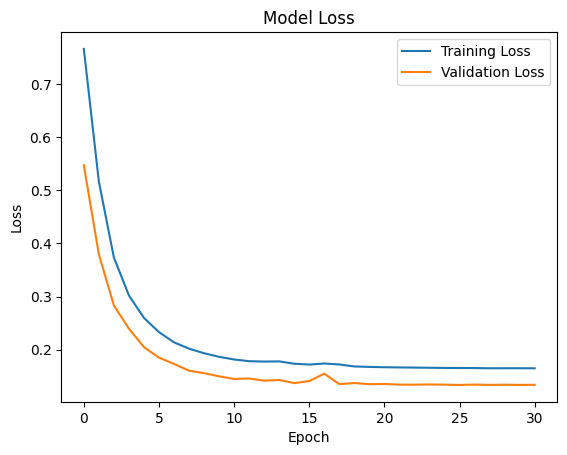

Epoch 1/4
5/5 [==============================] - 30s 7s/step - loss: 0.1468 - mae: 0.2793 - val_loss: 0.1338 - val_mae: 0.2576
Epoch 2/4
5/5 [==============================] - 27s 6s/step - loss: 0.1469 - mae: 0.2793 - val_loss: 0.1337 - val_mae: 0.2572
Epoch 3/4
5/5 [==============================] - 27s 6s/step - loss: 0.1470 - mae: 0.2791 - val_loss: 0.1336 - val_mae: 0.2568
Epoch 4/4
5/5 [==============================] - 28s 6s/step - loss: 0.1466 - mae: 0.2784 - val_loss: 0.1335 - val_mae: 0.2564


In [ ]:
model_pipeline = WindTurbinePipeline(model_checkpoint)
model_pipeline.train(df, epoch=35)

In [ ]:
def plot_predictions_with_generator(model, generator,scaler, num_batches=None):
    all_predictions = []
    all_actuals = []

    if num_batches is None:
        num_batches = len(generator)

    for i in range(num_batches):
        (batch_x, decoder_input), batch_y = generator[i]
        predictions = model.predict([batch_x, decoder_input])
        all_predictions.extend(predictions.flatten())
        all_actuals.extend(batch_y.flatten())

    all_predictions = np.array(all_predictions)
    all_actuals = np.array(all_actuals)

    # Create dummy arrays with the same shape as the original data
    dummy_array_pred = np.zeros((len(all_predictions), scaler.scale_.shape[0]))
    dummy_array_actual = np.zeros((len(all_actuals), scaler.scale_.shape[0]))

    # Place the predictions and actuals in the column corresponding to 'Active Power avg'
    active_power_col_index = 2  # Assuming 'Active Power avg' is the 3rd column in the original DataFrame
    dummy_array_pred[:, active_power_col_index] = all_predictions
    dummy_array_actual[:, active_power_col_index] = all_actuals

    # Inverse transform using the original scaler
    all_predictions = scaler.inverse_transform(dummy_array_pred)[:, active_power_col_index]
    all_actuals = scaler.inverse_transform(dummy_array_actual)[:, active_power_col_index]


    df = pd.DataFrame(data={'Predictions': all_predictions, 'Actuals': all_actuals})

    plt.figure(figsize=(20, 8))
    plt.scatter(range(len(df)),df['Predictions'], label='Predictions')
    plt.scatter(range(len(df)),df['Actuals'], label='Actuals')
    plt.legend()
    plt.show()
